<a href="https://colab.research.google.com/github/Neulvo/TIL/blob/master/seq2seq_tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

In [ ]:
from matplotlib import rc
from matplotlib import font_manager as fm
from matplotlib import rcParams
import matplotlib as mpl
#nanum 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
#여기가 폰트 사이즈를 정하는 곳.
font_name = fm.FontProperties(fname=path, size=16).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

sys_font number: 48
nanum_font number: 31
NanumBarunGothic


In [ ]:
path_to_file='/content/drive/My Drive/NLP/data/kor.xlsx'

In [ ]:
kor_eng= pd.read_excel(path_to_file, sheet_name='Sheet1') 

In [ ]:
kor_eng

,mid_sid,ko,en
0,1,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,2,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,3,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,4,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,5,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.
...,...,...,...
74995,74996,나의 고민은 학교가 멀어서 통학하기 힘들어.,My worry is commuting to school because it's t...
74996,74997,난 지금 내고양이때문에 충분히 힘들어.,I am going under enough difficulties because o...
74997,74998,나와 대화가 어려운 것이 많이 힘들어?,Is having difficulties in talking with me too ...
74998,74999,하루에 한번 연락하는게 그렇게 힘들어?,Is it that difficult to call once a day?


In [ ]:
 # Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  # w = unicode_to_ascii(w.lower().strip())
  w=w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z가-힣?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(lines, num_examples):
  # lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)
 

In [ ]:
kor_eng_corp=(kor_eng['ko']+'\t'+kor_eng['en']).tolist()

In [ ]:
kor_eng_corp

In [ ]:
ko, en = create_dataset(kor_eng_corp, None)
print(ko[-1])
print(en[-1])


<start> 어린 아이들이 스포츠를 즐기기엔 많이 힘들죠 . <end>
<start> it is difficult for young children to enjoy sports . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
 def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [ ]:
# Try experimenting with the size of that dataset
num_examples = 63000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(kor_eng_corp, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
 

In [ ]:
 # Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.20633334)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


50000 50000 13000 13000


In [ ]:
def convert(lang, tensor):
 for t in tensor:
   if t!=0:
     print ("%d ----> %s" % (t, lang.index_word[t]))
 

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])
 

Input Language; index to word mapping
1 ----> <start>
70 ----> all
14 ----> of
5 ----> the
2775 ----> sudden
10 ----> ,
4 ----> i
320 ----> thought
19 ----> that
4 ----> i
435 ----> wanted
6 ----> to
363 ----> read
5 ----> the
214 ----> book
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> 나는
18134 ----> 한순간에
12 ----> 그
300 ----> 책을
1092 ----> 읽고
3396 ----> 싶다는
438 ----> 마음이
269 ----> 들었어
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 1000
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
 

(TensorShape([64, 21]), TensorShape([64, 21]))

In [ ]:
 class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
 

Encoder output shape: (batch size, sequence length, units) (64, 21, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
 def __init__(self, units):
   super(BahdanauAttention, self).__init__()
   self.W1 = tf.keras.layers.Dense(units)
   self.W2 = tf.keras.layers.Dense(units)
   self.V = tf.keras.layers.Dense(1)

 def call(self, query, values):
   # query hidden state shape == (batch_size, hidden size)
   # query_with_time_axis shape == (batch_size, 1, hidden size)
   # values shape == (batch_size, max_len, hidden size)
   # we are doing this to broadcast addition along the time axis to calculate the score
   query_with_time_axis = tf.expand_dims(query, 1)

   # score shape == (batch_size, max_length, 1)
   # we get 1 at the last axis because we are applying score to self.V
   # the shape of the tensor before applying self.V is (batch_size, max_length, units)
   score = self.V(tf.nn.tanh(
       self.W1(query_with_time_axis) + self.W2(values)))

   # attention_weights shape == (batch_size, max_length, 1)
   attention_weights = tf.nn.softmax(score, axis=1)

   # context_vector shape after sum == (batch_size, hidden_size)
   context_vector = attention_weights * values
   context_vector = tf.reduce_sum(context_vector, axis=1)

   return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
 

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 21, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights
 

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
 

Decoder output shape: (batch_size, vocab size) (64, 75140)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
 

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder=decoder)
 

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  # if (epoch + 1) % 2 == 0:
  #   checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3271
Epoch 1 Batch 100 Loss 3.0382
Epoch 1 Batch 200 Loss 2.9610
Epoch 1 Batch 300 Loss 2.6959
Epoch 1 Batch 400 Loss 2.6633
Epoch 1 Batch 500 Loss 2.6894
Epoch 1 Batch 600 Loss 2.8485
Epoch 1 Batch 700 Loss 2.7536
Epoch 1 Loss 2.8151
Time taken for 1 epoch 515.976241350174 sec

Epoch 2 Batch 0 Loss 2.5220
Epoch 2 Batch 100 Loss 2.3248
Epoch 2 Batch 200 Loss 2.5413
Epoch 2 Batch 300 Loss 2.4155
Epoch 2 Batch 400 Loss 2.1877
Epoch 2 Batch 500 Loss 2.3007
Epoch 2 Batch 600 Loss 2.3006
Epoch 2 Batch 700 Loss 2.2340
Epoch 2 Loss 2.3358
Time taken for 1 epoch 485.70932841300964 sec

Epoch 3 Batch 0 Loss 1.9023
Epoch 3 Batch 100 Loss 1.9384
Epoch 3 Batch 200 Loss 1.8395
Epoch 3 Batch 300 Loss 1.8732
Epoch 3 Batch 400 Loss 1.8452
Epoch 3 Batch 500 Loss 1.9032
Epoch 3 Batch 600 Loss 1.8271
Epoch 3 Batch 700 Loss 1.8890
Epoch 3 Loss 1.8821
Time taken for 1 epoch 478.42456340789795 sec

Epoch 4 Batch 0 Loss 1.4212
Epoch 4 Batch 100 Loss 1.2974
Epoch 4 Batch 200 Loss 1.2904

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))
 

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
 

Input: <start> sir , i don t understand this sentence here . <end>
Predicted translation: 선생님 이문장이 이해가 안 가요 . <end> 


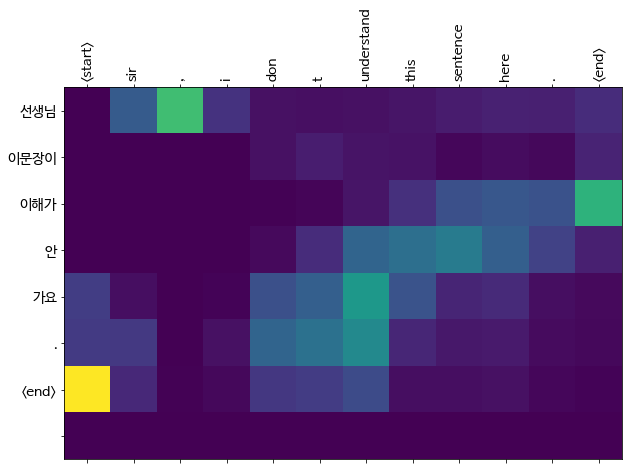

In [ ]:
 translate(u'sir , i don t understand this sentence here .')


Input: <start> i go to the attic every evening to meet bat . <end>
Predicted translation: 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end> 


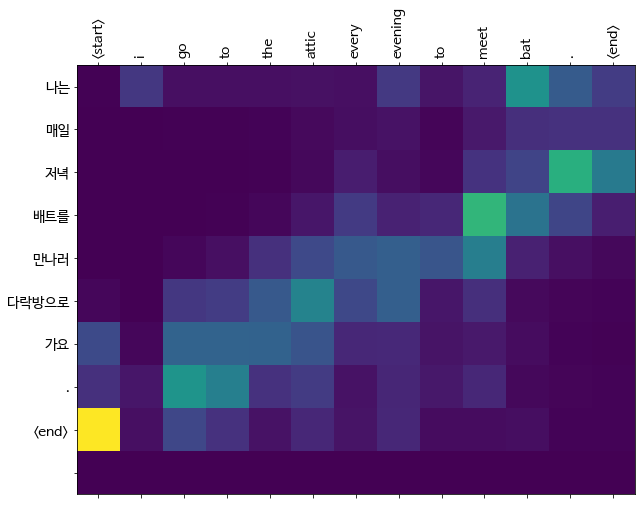

In [ ]:
translate('i go to the attic every evening to meet bat .')

Input: <start> time flies when you start using the computer . <end>
Predicted translation: 컴퓨터를 시작하면 시간이 되면 만나요 . <end> 


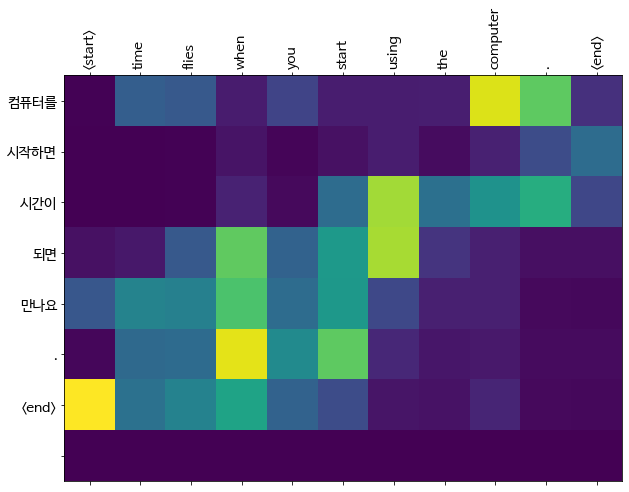

In [ ]:
translate(u'time flies when you start using the computer .')

Input: <start> manchester united the world best team ever . <end>
Predicted translation: 간호사는 환자를 평소보다 더 주위깊게 살펴야 해요 . <end> 


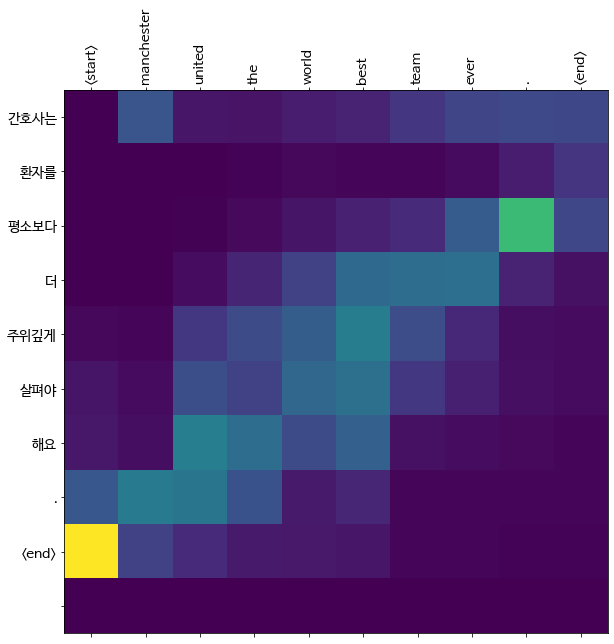

In [ ]:
 translate(u'Manchester United the world best team ever.')

In [ ]:
en[6:11]

('<start> i go to dormitory as soon as i finished class . <end>',
 '<start> korean men have to obligatorily join the army in twenty . <end>',
 '<start> i m going to korea for visa tonight . <end>',
 '<start> today , i am going to pick up the new car . <end>',
 '<start> i m meeting a guest for urgent matters . <end>')

Input: <start> i go to dormitory as soon as i finished class . <end>
Predicted translation: 나는 일어나자마자 아내와 예약하고 있어 . <end> 


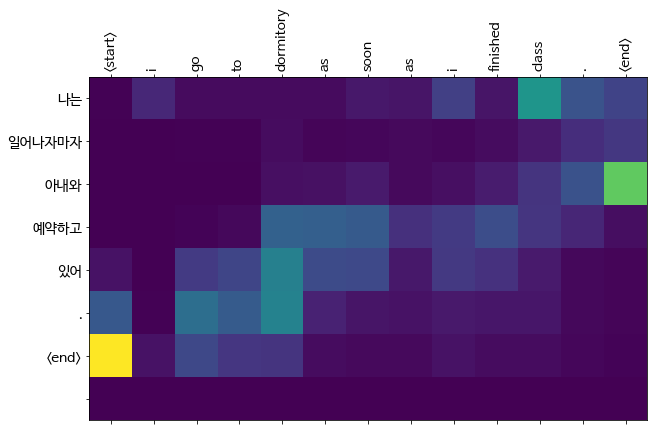

In [ ]:
 translate(u'i go to dormitory as soon as i finished class .')

Input: <start> today , i am going to pick up the new car . <end>
Predicted translation: 오늘 새 자동차를 받으러 가요 . <end> 


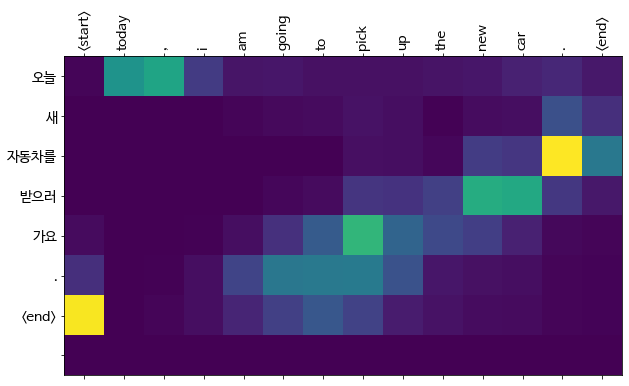

In [ ]:
translate(u'today , i am going to pick up the new car .')

Input: <start> i am going to dormitory to pick up my purse <end>
Predicted translation: 나는 나의 카드로 결제 하려고 해요 . <end> 


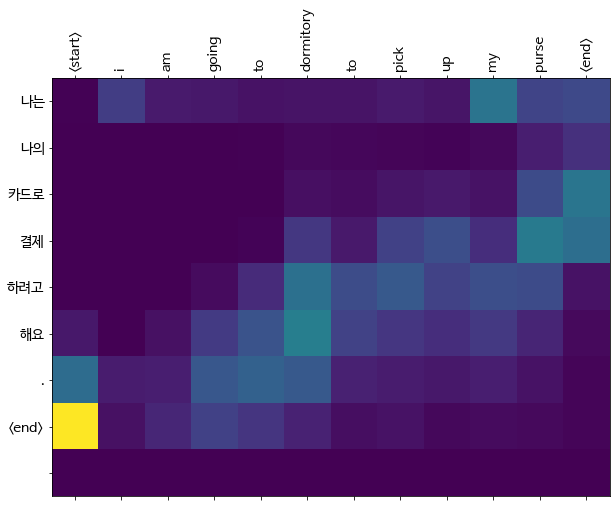

In [ ]:
translate('I am going to dormitory to pick up my purse')

In [ ]:
inp_lang.word_index

Input: <start> i want to go home . <end>
Predicted translation: 나는 매일 같이 가고 싶어 . <end> 


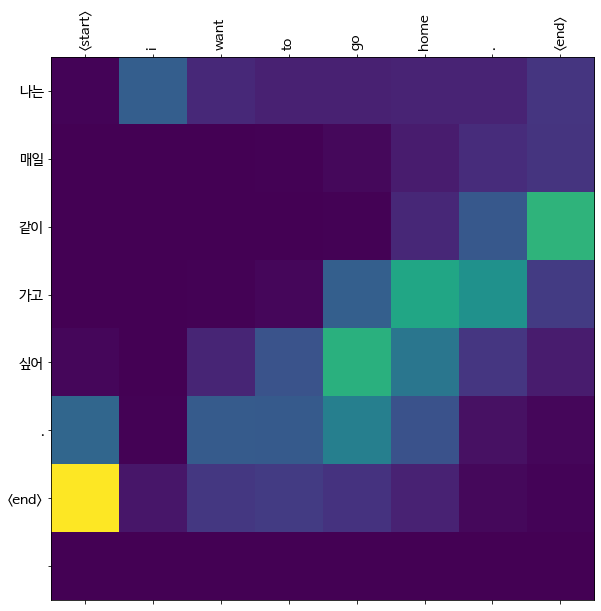

In [ ]:
translate('I want to go home.')

Input: <start> i want to be free <end>
Predicted translation: 나는 책임 있는 팀장이 되고 싶어 . <end> 


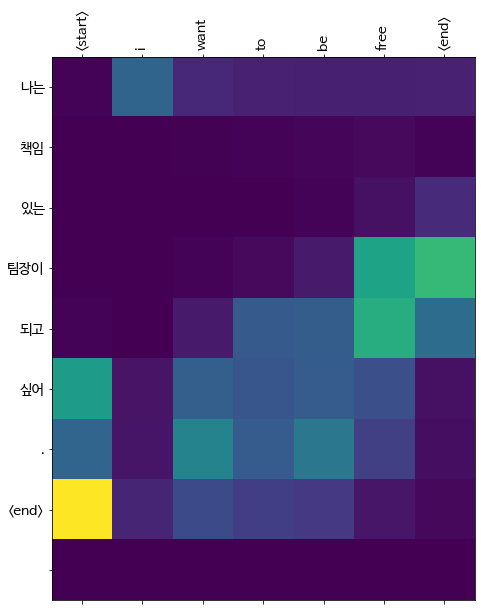

In [ ]:
translate('I want to be free')

Input: <start> yesterday all my trouble seem so far away . <end>
Predicted translation: 어제 내 말을 많이 너무 활동적이라는 것 같아 . <end> 


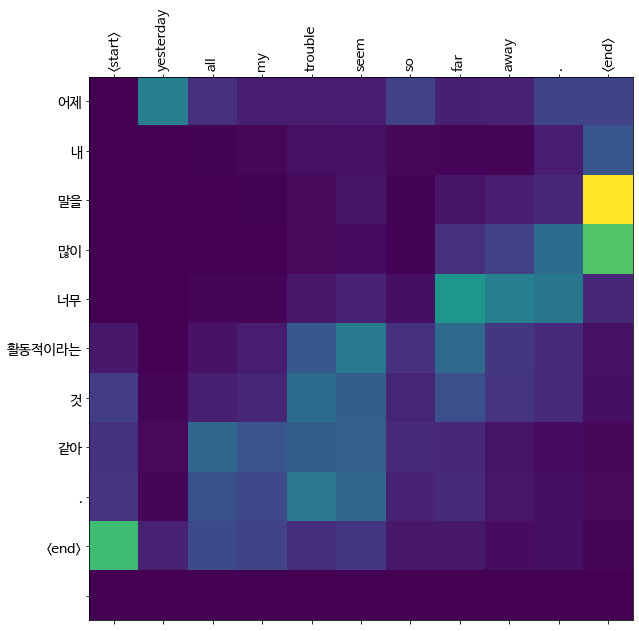

In [ ]:
translate('yesterday all my trouble seem so far away.')

Input: <start> yes . <end>
Predicted translation: 네 , 지금 피아노 학원에 있어요 . <end> 


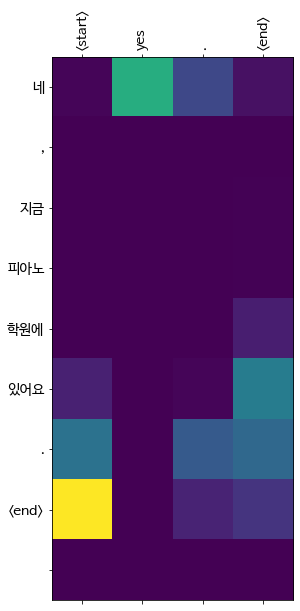

In [ ]:
translate('yes.')

Input: <start> korean men have to obligatorily join the army in twenty one <end>
Predicted translation: 한국 남자는 군대에 갈 의무가 있어 . <end> 


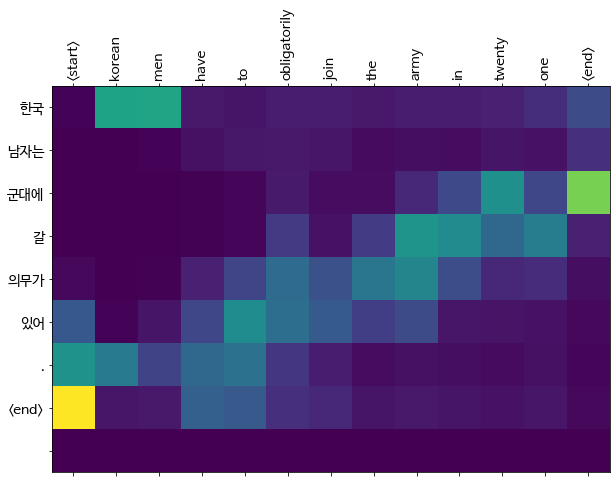

In [ ]:
translate(u' korean men have to obligatorily join the army in twenty one ')

Input: <start> i believe in you <end>
Predicted translation: 당신이 학생이기 때문에 이해했어 . <end> 


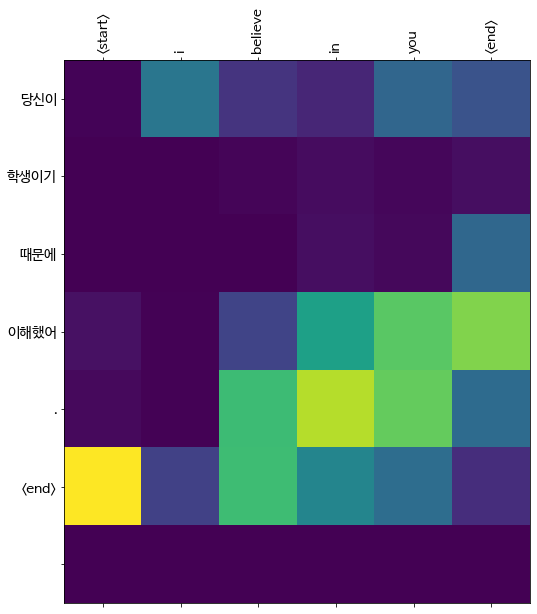

In [ ]:
translate('I believe in you')

Input: <start> 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end>
Predicted translation: i go to the attic every day to the evening . <end> 


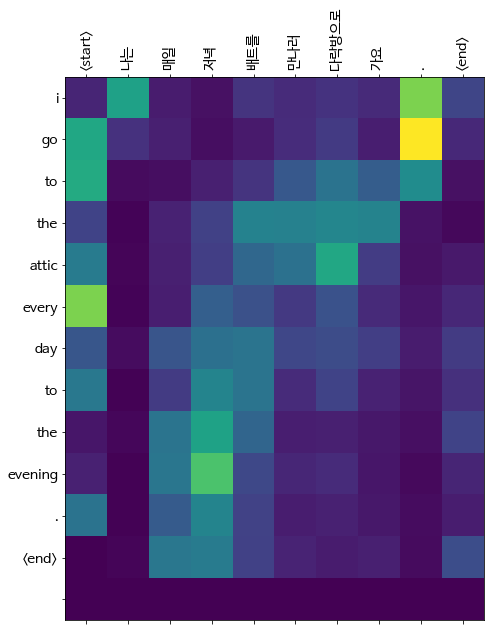

Input: <start> 선생님 이문장이 이해가 안 가요 . <end>
Predicted translation: sir , i don t like this situation here . <end> 


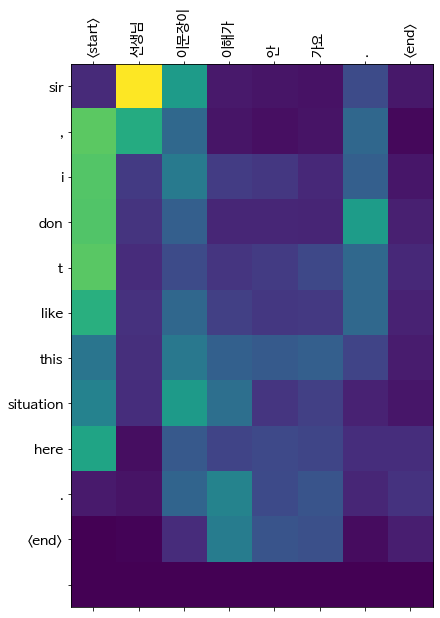

Input: <start> 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end>
Predicted translation: i get off little bit late if i have a week ago . <end> 


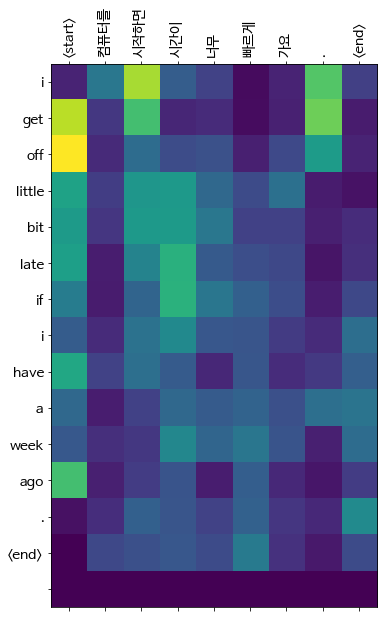

Input: <start> 나는 오늘 자정에 한국으로 돌아 가요 . <end>
Predicted translation: i m going back to korea today at midnight . <end> 


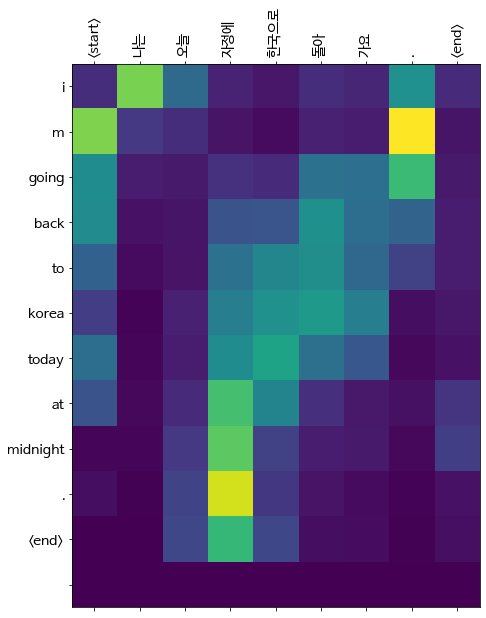

Input: <start> 나는 일어나자마자 화장실에 가요 . <end>
Predicted translation: i go to the library as i watch the library . <end> 


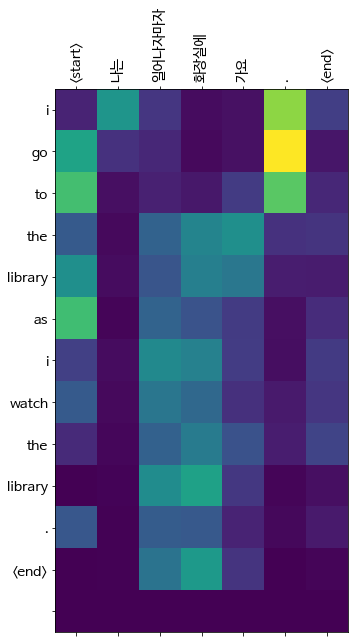

Input: <start> 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end>
Predicted translation: i m not be able to stop right now , i don t feel free to sleep now . <end> 


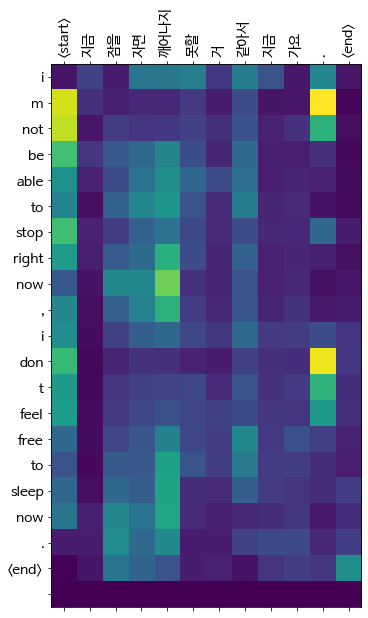

Input: <start> 학교가 끝나자마자 기숙사로 가요 . <end>
Predicted translation: i go to dormitory as soon as i finished from school . <end> 


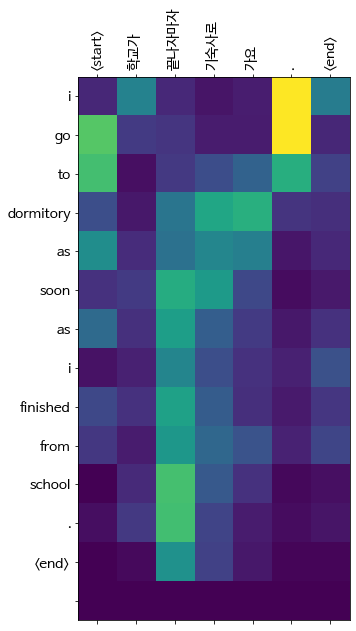

Input: <start> 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end>
Predicted translation: korean saunas get to japan , i have been in korea . <end> 


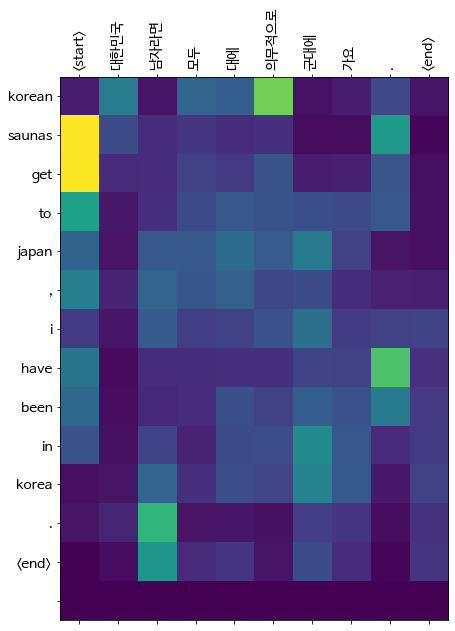

Input: <start> 오늘밤에 비자 때문에 한국에 가요 . <end>
Predicted translation: i m going to korea for coming here early . <end> 


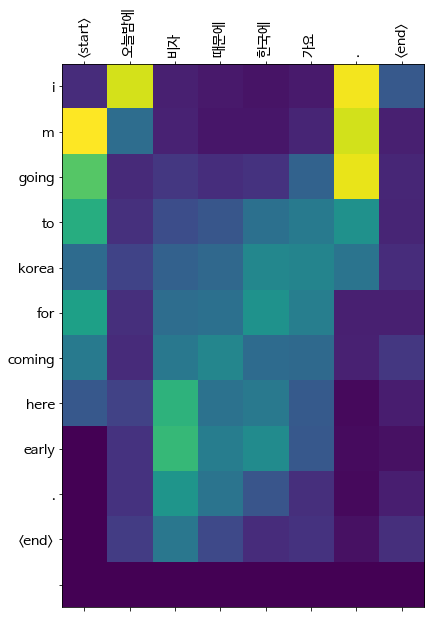

Input: <start> 오늘은 새 자동차를 받으러 가요 . <end>
Predicted translation: i m going to take a car work this morning . <end> 


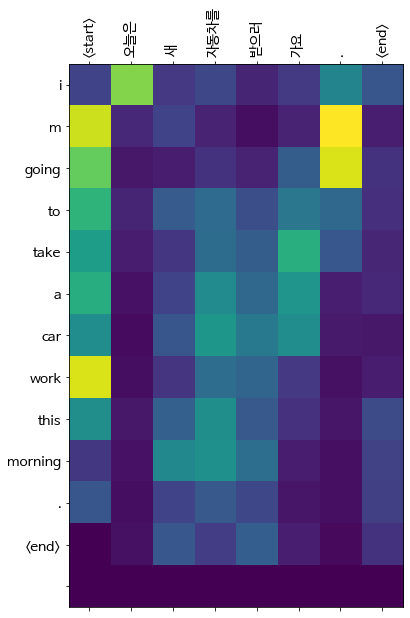

In [ ]:
# right order sentece, 1 layers GRU with 1000 embedding_dims
for k in ko[:10]:
  kor=re.sub('<[^>]*>','',k)
  translate(kor)

Input: <start> i go to the attic every evening to meet bat . <end>
Predicted translation: 나는 매일 저녁 배트를 만나러 다락방으로 가요 . <end> 


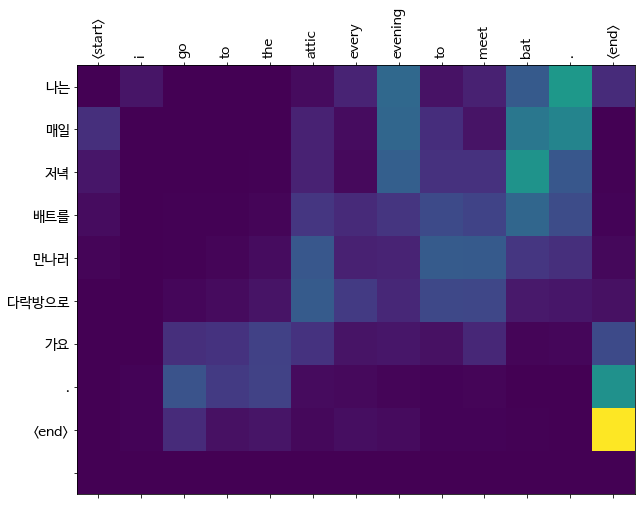

Input: <start> sir , i don t understand this sentence here . <end>
Predicted translation: 선생님 이문장이 이해가 이해가 없어요 . <end> 


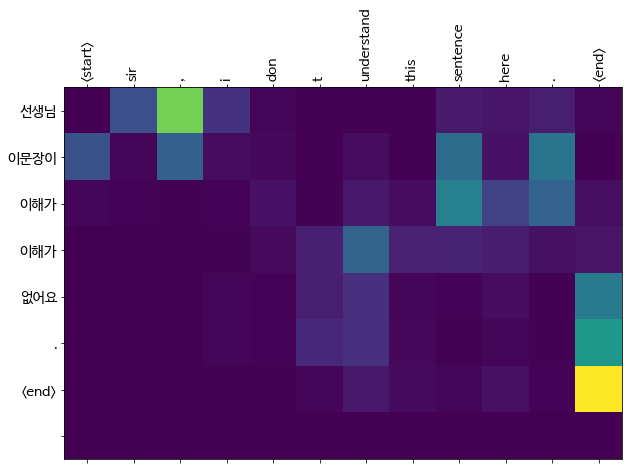

Input: <start> time flies when you start using the computer . <end>
Predicted translation: 컴퓨터를 시작하면 시간이 너무 빠르게 가요 . <end> 


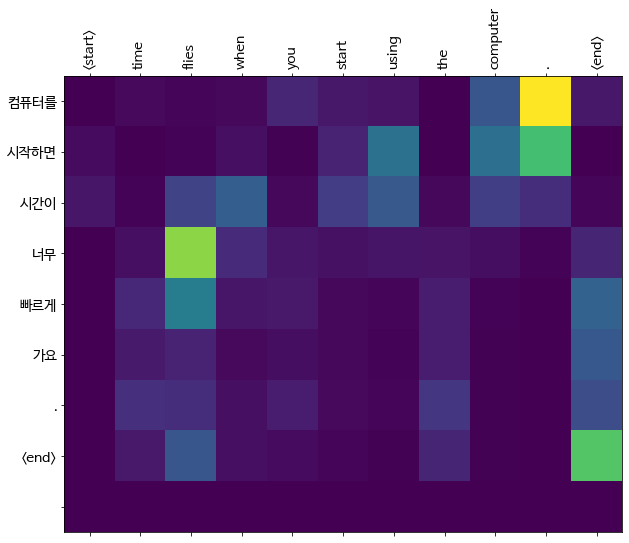

Input: <start> i m going back to korea today at midnight . <end>
Predicted translation: 나는 오늘 자정에 한국으로 돌아 가요 . <end> 


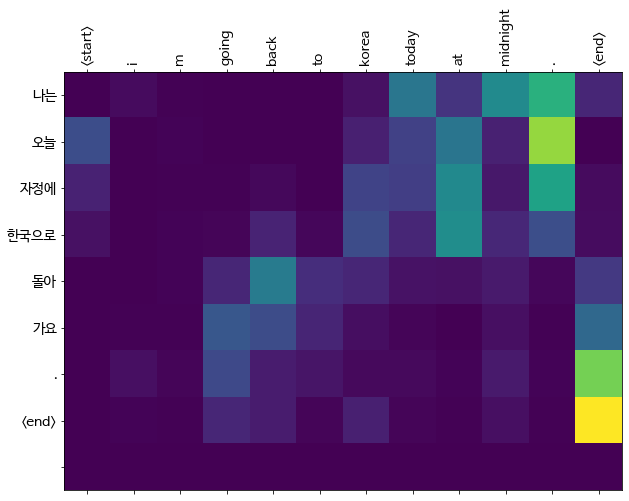

Input: <start> i go to bathroom as soon as i wake up . <end>
Predicted translation: 나는 일어나자마자 화장실에 가요 . <end> 


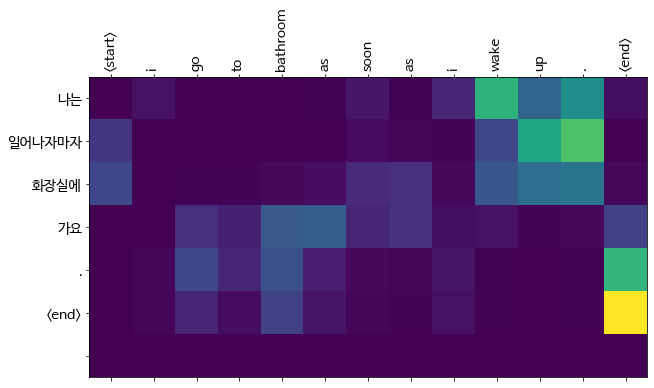

Input: <start> if i fall asleep i might not get up so i will go right now . <end>
Predicted translation: 지금 잠을 자면 깨어나지 못할 거 같아서 지금 가요 . <end> 


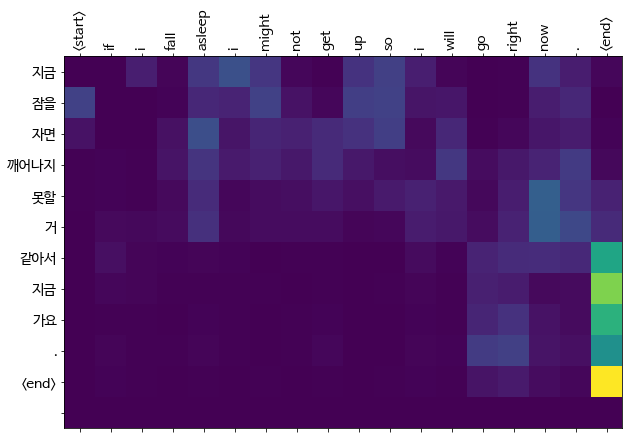

Input: <start> i go to dormitory as soon as i finished class . <end>
Predicted translation: 학교가 끝나자마자 기숙사로 가요 . <end> 


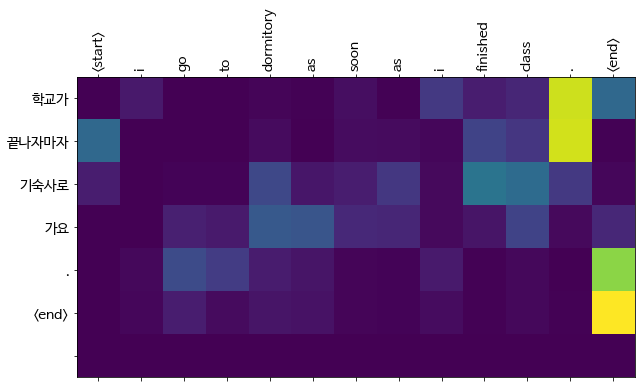

Input: <start> korean men have to obligatorily join the army in twenty . <end>
Predicted translation: 대한민국 남자라면 모두 대에 의무적으로 군대에 가요 . <end> 


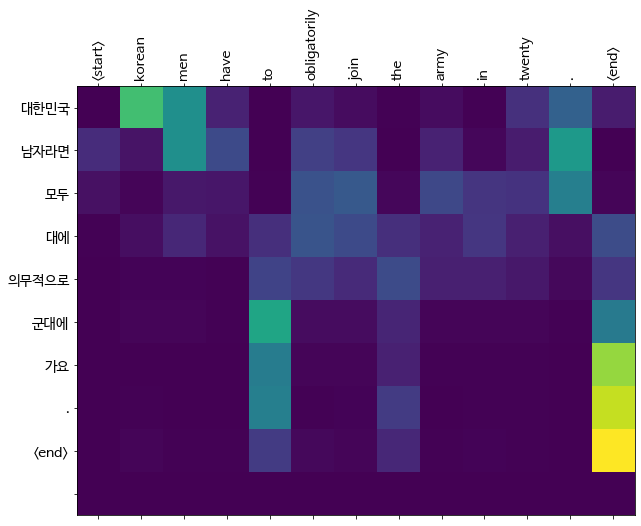

Input: <start> i m going to korea for visa tonight . <end>
Predicted translation: 오늘밤에 비자 때문에 한국에 가요 . <end> 


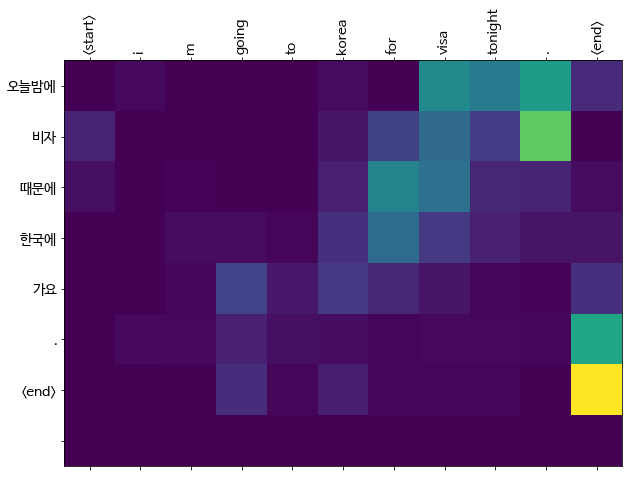

Input: <start> today , i am going to pick up the new car . <end>
Predicted translation: 오늘은 새 자동차를 받으러 가요 . <end> 


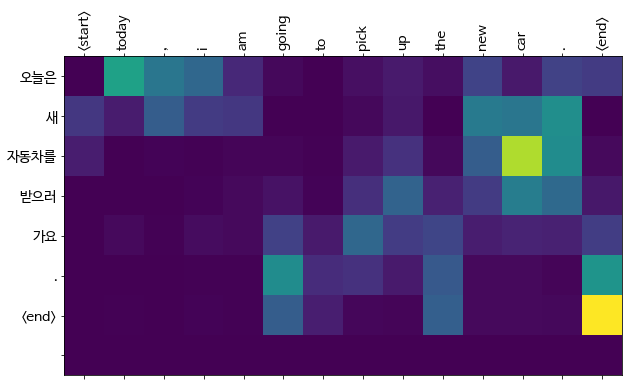

In [ ]:
# right order sentece, 1 layers GRU with 1000 embedding_dims
for k in en[:10]:
  kor=re.sub('<[^>]*>','',k)
  translate(kor)

In [ ]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_avg(doc, target_doc):
  bleu_score=[]
  smoothie = SmoothingFunction().method4
  for input_sentence, target_sentence in tqdm(zip(doc,target_doc)):
    try:
      input_sentence=re.sub('<[^>]*>','',input_sentence)
      target_sentence=re.sub('<[^>]*>','',target_sentence)
      result, sentence, attention_plot = evaluate(input_sentence)
      bleu_score.append(nltk.translate.bleu_score.sentence_bleu(target_sentence.split(' '),result.split(' '),smoothing_function=smoothie))
    except:
      pass
  return np.mean(bleu_score)

In [ ]:
# right order sentece, 1 layers GRU with 1000 embedding_dims
bleu_avg(ko[63001:],en[63001:])

0.21776383325598686

In [ ]:
# right order sentece, 1 layers GRU with 1000 embedding_dims
bleu_avg(en[63001:],ko[63001:])

0.2021102727536406

In [ ]:
# right order sentece, 1 layers GRU with 1000 embedding_dims
bleu_avg(en[:63000],ko[:63000])

0.21339550885076813